#### Q1. Read in data

Read in the files gold.txt and labels.txt.  The gold DataFrame should have columns url and category, while the labels DataFrame should have columns turk, url and category.

##### <b>NOTE : </b>
We have cleaned the dataset in three steps : 
<ul>
    <li>Remove extra whitespaces and inbetween white spaces in the URL</li>
    <li>Convert url to lowercase, Becasue url's are not casesensitive, and we do not want to differentiate between <ul><li>http://FoxNews.com</li> <li> http://foxnews.com</li></ul>
</li>
    <li>Drop all duplicates from unknown labels. That is drop all cases where the same turk, has responded to same url with the same category. Such as the cases shown below : 
    
          turk	        url	           category
    A1PXXEOGQ76RNJ	http://1-yo.com	     G
    A1PXXEOGQ76RNJ	http://1-yo.com	     G

        
   </li>
</ul>

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

#Read Datasets with \t seperator
df_gold = pd.read_csv('gold.txt', delimiter = "\t" , header=None)
df_label = pd.read_csv('labels.txt', delimiter = "\t", header=None)

#Assign column names
df_gold.columns =['url', 'category']
df_label.columns =['turk','url', 'category']  


#Clean the datasets - Remove differences due to capital case, and remove duplicate rows. 

df_label['url'] = df_label['url'].str.strip()                            #Remove Extra White Space
df_label['url'] = df_label['url'].str.replace('\s', '')                  #Remove Inbetween White Space
df_label['url'] = df_label['url'].str.lower()                            #Convert to lower
df_label=df_label.drop_duplicates(subset=['turk','url', 'category'] , )  #Remove duplicate values, i.e, same turk categorizing the same url twice. 

display(df_gold.head(4))
display(df_label.head(4))

,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X


,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G


#### Q2. Split labels DataFrame into two DataFrames

Split the labels DataFrame into two, labelsongold and labelsunknown.the former containing all rows where the url is present in the gold set, and the latter one contains all remaining rows of labels.

In [3]:
df_labelsongold=df_label[df_label['url'].isin(df_gold['url'])]
df_labelsunknown=df_label[~df_label['url'].isin(df_gold['url'])]

display(df_labelsongold.head(4))
display(df_labelsunknown.head(4))

,turk,url,category
245,A1253FXHCZ9CWM,http://0800-horoscope.com,G
246,A153PKAL7OAY36,http://0800-horoscope.com,G
247,A1FV9SAPL5C6KY,http://0800-horoscope.com,G
248,A1JTOT0DWM6QGL,http://0800-horoscope.com,G


,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G


#### Q3. Compute accuracies of turks

Create a rater_goodness DataFrame that is indexed by turk, and has two columns:  the number of ratings, and the average correctness of ratings foreach turk (both on gold set urls).

In [4]:
df_turk_check=df_labelsongold.merge(df_gold, how='left', on='url' , suffixes=['_turkselection','_correctselection'])
df_turk_check['correct']=df_turk_check['category_turkselection']==df_turk_check['category_correctselection']

number_of_total_ratings=df_turk_check.groupby('turk')['url'].count()
number_of_correct_ratings=df_turk_check.groupby('turk')['correct'].apply(lambda x : x[x==True].count())
number_of_wrong_ratings=df_turk_check.groupby('turk')['correct'].apply(lambda x : x[x==False].count())

rater_goodness=pd.DataFrame(dict(number_of_total_ratings = number_of_total_ratings, number_of_correct_ratings = number_of_correct_ratings, number_of_wrong_ratings=number_of_wrong_ratings))
rater_goodness['average_correctness']=rater_goodness['number_of_correct_ratings']/rater_goodness['number_of_total_ratings']

display(rater_goodness.head(4))

,number_of_total_ratings,number_of_correct_ratings,number_of_wrong_ratings,average_correctness
turk,,,,
A112DVP1KG4QZU,1,1,0,1.000000
A1253FXHCZ9CWM,28,14,14,0.500000
A12CY1Q7XKJJDE,1,1,0,1.000000
A12RE8G66WTO8B,18,13,5,0.722222


#### Q4.  Calculate odds ratios

If someone is correct p fraction of the time, the odds of success are defined as: 

odds = p/(1.001−p). 

Attach a column called odds to the rater_goodness DataFrame, using the average correctness of the turk as his or her p.

In [5]:
rater_goodness['odds']=rater_goodness['average_correctness']/(1.001-rater_goodness['average_correctness'])

display(rater_goodness[['number_of_total_ratings','number_of_correct_ratings','average_correctness','odds']].head(4))

,number_of_total_ratings,number_of_correct_ratings,average_correctness,odds
turk,,,,
A112DVP1KG4QZU,1,1,1.000000,1000.000000
A1253FXHCZ9CWM,28,14,0.500000,0.998004
A12CY1Q7XKJJDE,1,1,1.000000,1000.000000
A12RE8G66WTO8B,18,13,0.722222,2.590674


#### Q5. Most accurate turks

List the top 10 most accurate turks who have rated at least 20 gold set URLs.

In [6]:
rater_goodness=rater_goodness.sort_values('average_correctness' , ascending=False)
top10_accurate_turks=rater_goodness[rater_goodness['number_of_total_ratings']>=20][0:10]

display(top10_accurate_turks[['number_of_total_ratings','odds']])
    

,number_of_total_ratings,odds
turk,,
A22C0PJUBFJTI0,32,14.763780
ATVALOQVDCMZW,96,6.337813
A23YQUBXZPKILZ,22,6.287227
AJSJVK40F5HM6,26,4.178273
A1HIXWH4OXT8S4,36,4.121660
A20PWAB7G3HDHU,20,3.980100
A3MA9V9UPGCOK7,65,3.626022
A32W20KGQXS0LL,23,3.583516
A3IP9KYNZZ028B,22,3.385106


#### Q6. Rating counts versus accuracy

One may imagine that a committed and accurate turk will rate lots of URLs. On the other hand, perhaps it is only the spammers who have the time to rate lots of URLs. <b> Is number of ratings by a turker on gold set URLs related to his or her accuracy? </b> There’s no fixed answer; just try to show some evidence for youranswer.

------------------------------------------------------------------------------------------
To explain the relationship between the two variables, we use two strategies: 
	 1. Draw Linear Regression Model to approxiamte the behaviour
	 2. Calculate Pearson Correlation
------------------------------------------------------------------------------------------
Observation 1 : The Linear ModelSeeing a near flat line, that is low slope, we can infer that the there is no relationship between the two variables.


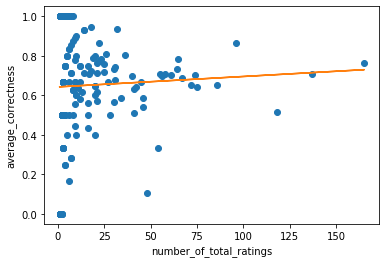

Observation 2 : The correlation between Accuracy and Number of : 0.033  we can infer no overall relationship again between the two variables.


In [7]:
x = np.array(rater_goodness['number_of_total_ratings'])
y = np.array(rater_goodness['average_correctness'])
plt.plot(x, y, 'o')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel("number_of_total_ratings")
plt.ylabel("average_correctness")


print('---'*30)
print('To explain the relationship between the two variables, we use two strategies: ')
print('\t 1. Draw Linear Regression Model to approxiamte the behaviour')
print('\t 2. Calculate Pearson Correlation')
print('---'*30)

print('Observation 1 : The Linear ModelSeeing a near flat line, that is low slope, we can infer that the there is no relationship between the two variables.'  )

plt.show()
corr, _ = pearsonr(x, y)

print('Observation 2 : The correlation between Accuracy and Number of : %.3f' % corr , ' we can infer no overall relationship again between the two variables.')


#### Q7. Overall predicted odds

Consider each url u that is not in the gold set, and each category c.  For the pair (u, c), calculate the product of odds of all turks who 
(a) rated url u as category c and 
(b) have rated more gold set urls than 75% of all turks who rated at least one gold-set url.


##### <b>NOTE : </b>
We have considered quantiles to be <b><u>greater than or equal to </u></b> the qualifying total. So, for example if the 0.25 quantile is 11, we consider all turks having atleast 11 responses.

In [8]:
qualifying_total_required = rater_goodness['number_of_total_ratings'].quantile(q=0.25) 

reliableturks=rater_goodness[rater_goodness['number_of_total_ratings']>=qualifying_total_required]
reliableturks=reliableturks.reset_index()

df_reliable_turk_responses=df_labelsunknown[df_labelsunknown['turk'].isin(reliableturks['turk'])]
df_reliable_turk_responses=df_reliable_turk_responses.merge(reliableturks, on='turk' , how='left')

df_overall_odds=df_reliable_turk_responses.groupby(['url', 'category'], as_index=False)['odds'].prod().rename(columns={'odds':'overall_odds'})

display(df_overall_odds.head(4))

,url,category,overall_odds
0,http://0-101.net,G,2.297602e+00
1,http://000.cc,G,2.218192e+03
2,http://000.cc,P,9.980040e-01
3,http://0000.jp,G,2.280073e+07


##### Q8. Predicted categories

Create a DataFrame (called result75, whose index is URLs not in the goldset,  and  with  two  columns  called top category and top odds.   The top category should be the category with the highest overall odds for that url,and the top odds should be the overall odds for that top category.These are our predictions,  and the confidence we have in them (higher overall odds implies greater confidence). If you want, you can check to see if the predicted categories make sense.

In [9]:
df_overall_odds=df_overall_odds.sort_values('overall_odds', ascending=False)
result75=df_overall_odds.drop_duplicates(subset=['url'], keep='first')
result75=result75.set_index('url')

display(result75.head(4))

,category,overall_odds
url,,
http://electriqueboutique.com,P,1.286287e+19
http://bharatstudent.com,G,9.287917e+16
http://webpandora.ru,G,2.728427e+16
http://ds-collection.net,G,2.728427e+16


##### Q9. Predicted categories using more turks

Questions 7 and 8 above only considered the ratings of turks who had rated enough  gold  set  URLs,  so  we  were  relatively  more  confident  about  their accuracies.  What happens if we loosen this restriction? Repeat the code of Q7 and Q8, but replacing 75% by 25% in the description of Q7 (i.e., we also consider turks who have far fewer gold set ratings).Call this result25. Now let’s see how these two results compare. 


Create a DataFrame whereboth  the  index  and  the  columns  are  the  various  categories,  and  the  cells contain  the  number  of  urls  with  these  as  the  top  categories  according  to result75 and result25. For example, the cell corresponding to the row category=R and the column category=G would be the number of URLs that were predicted to be R by result75 but predicted to be G by result25. 


Where are the most errors?

##### <b>NOTE : </b>
We have calculated error as follows 
<ul>
    <li><b>Total : </b> This is the total number of URL's that overlap between the result_75 and result_25 matrix for that category</li>
    <li><b>Mismatch answers : </b> We note the number of responses by result_25 that do not match our more accurate set result_75. That is, if result_75 has suggested there are 284 responses in R category, we look for the number of responses that were marked othersise (P,X,G) category by result_25. (72+122+33)    </li>
    <li><b>Error Percentage :</b> Is (Mismatch Answers/Total)*100</li>
</ul>        

In [10]:
qualifying_total_required_75 = rater_goodness['number_of_total_ratings'].quantile(q=0.75) 

reliableturks_75=rater_goodness[rater_goodness['number_of_total_ratings']>=qualifying_total_required_75]
reliableturks_75=reliableturks_75.reset_index()

df_reliable_turk_responses_75=df_labelsunknown[df_labelsunknown['turk'].isin(reliableturks_75['turk'])]
df_reliable_turk_responses_75=df_reliable_turk_responses_75.merge(reliableturks_75, on='turk' , how='left')

df_overall_odds_75=df_reliable_turk_responses_75.groupby(['url', 'category'], as_index=False)['odds'].prod().rename(columns={'odds':'overall_odds'})

df_overall_odds_75=df_overall_odds_75.sort_values('overall_odds', ascending=False)
result25=df_overall_odds_75.drop_duplicates(subset=['url'], keep='first')
result25=result25.set_index('url')


overall_results=result25.join(result75, how='left', lsuffix='_25', rsuffix='_75')
error_matrix_creation=overall_results.groupby(['category_25', 'category_75'], as_index=False).count()

error_matrix=error_matrix_creation.pivot(index='category_75', columns='category_25')['overall_odds_25']

print('Error Matrix ! ')
display(error_matrix)


#Calculation of Error : 

error_percentage={}
categories=error_matrix_creation['category_75'].drop_duplicates().to_list()
for category in categories:
    tot=error_matrix_creation[error_matrix_creation['category_75']==category]['overall_odds_25'].sum()
    corr=error_matrix_creation[error_matrix_creation['category_75']==error_matrix_creation['category_25']]
    correct=corr[corr['category_25']==category]['overall_odds_25'].item()
    error_percentage[category]=(((tot-correct)/tot)*100).round(2)

error_percentage_df=pd.DataFrame(error_percentage.items())
error_percentage_df.columns =['Category', 'Error Percentage(%)']
error_percentage_df=error_percentage_df.sort_values('Error Percentage(%)' , ascending=False)


print('Error Percentage for each Category')
display(error_percentage_df)
print('Therefore we can conclude that maximum error, is present for R category when displayed in percentage')

Error Matrix ! 


category_25,G,P,R,X
category_75,,,,
G,7837,213,22,80
P,855,304,33,10
R,286,72,122,33
X,258,31,38,446


Error Percentage for each Category


,Category,Error Percentage(%)
2,R,76.22
1,P,74.71
3,X,42.30
0,G,3.86


Therefore we can conclude that maximum error, is present for R category when displayed in percentage
